In [1]:
from omegaconf import OmegaConf
from dataset import MnistDataset
from model import UCCModel, DRNOnlyModel
from torch.nn import functional as F

The main problem here is to investigate the gradient values between the ucc-classifier and the encoder.
1. Initialize a model. Perform forward propagation and compute total gradients propagated through (mean, std deviation) 
2. Remember to freeze the model

Also observe distribution of weights, biases between layers.


(11, 11)
(11, 11)
(11, 11)
(4, 11)


In [24]:
from torch.utils.data import DataLoader

dataset = MnistDataset(
    num_instances=12,
    num_samples_per_class=16,
    digit_arr=range(0,10),
    ucc_start=1,
    ucc_end=4
)

dataloader = DataLoader(dataset, batch_size=1)

x_train shape: torch.Size([50000, 1, 28, 28])
50000 train samples
10000 val samples


In [25]:
# TODO I coded the num_bins and num_nodes wrongly
# Convert ucc_model.num_nodes to use ucc_model.num_bins instead

In [34]:
import copy


cfg = OmegaConf.load("D:/UCC-DRN-Pytorch/mnist/mlruns/380446538050732248/bd12d4fab96543138115acd50d3a7412/artifacts/config.yaml")
cfg.model.kde_model.num_bins = cfg.model.drn.num_bins = cfg.model.drn.hidden_q = 11

ucc_model = UCCModel(cfg)
ucc_model_2 = UCCModel(cfg)
drn_model = DRNOnlyModel(cfg)
encoder = ucc_model.encoder
encoder_2 = ucc_model_2.encoder

(11, 11)
(11, 11)
(11, 11)
(4, 11)


In [35]:
import torch
dense_classifier = ucc_model.ucc_classifier 
ucc_model.num_nodes = cfg.args.num_bins
optimizer = torch.optim.Adam(params=encoder.parameters(), lr=0.1)
optimizer_2 = torch.optim.Adam(params=encoder_2.parameters(), lr=0.1)
def compute_measures(x: torch.Tensor):
    return x.mean(), x.std()

mean_1_list=[]
mean_2_list=[]
std_1_list=[]
std_2_list=[]
for data, labels in dataloader:
    print(data.shape)
    x = data.view(-1, 1, 28, 28)
    # with torch.no_grad():
    features = encoder(x).view(1, 12, 10)
    features.retain_grad()
    distributions = ucc_model.kde(features, 11, ucc_model.sigma)
    outputs_1 = dense_classifier(distributions)
    loss_1 = F.cross_entropy(outputs_1, labels)
    loss_1.backward()
    grad_1 = features.grad
    # optimizer.step()
    
    features_2 = encoder_2(x).view(1, 12, 10)
    features_2.retain_grad()
    # distributions_2 = ucc_model_2.kde(features, 11, ucc_model.sigma)
    outputs_2 = drn_model(features_2)
    loss_2 = F.cross_entropy(outputs_2, labels)
    loss_2.backward()
    grad_2 = features_2.grad
    mean_1, std_1 = compute_measures(grad_1)
    mean_2, std_2 = compute_measures(grad_2)
    mean_1_list.append(mean_1)
    mean_2_list.append(mean_2)
    std_1_list.append(std_1)
    std_2_list.append(std_2)
    # # loss_1.backward()
    # print(labels.shape)
    # break

torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Size([1, 12, 1, 28, 28])
torch.Si

KeyboardInterrupt: 

In [41]:
float(mean_1_list[0])

-5.805506225442514e-05

In [42]:
def convert_to_float(list):
    return [float(l) for l in list]

In [43]:
import json
with open("mean_std.json", "w") as file:
    file.write(json.dumps(
        {
            "mean_1": convert_to_float(mean_1_list),
            "mean_2": convert_to_float(mean_2_list),
            "std_1": convert_to_float(std_1_list),
            "std_2": convert_to_float(std_2_list)
        }
    ))


In [6]:
import json
with open("mean_std.json", "r") as file:
    data = json.loads(file.read())

In [7]:
data

{'mean_1': [-5.805506225442514e-05,
  0.0001833028654800728,
  -0.00015756665379740298,
  9.133360435953364e-06,
  -2.2448626623372547e-05,
  0.00020018995564896613,
  -0.0001605355500942096,
  2.7207723178435117e-05,
  -6.424581806641072e-05,
  0.00018516996351536363,
  -0.0001411704724887386,
  2.8956332243978977e-05,
  -5.4133666708366945e-05,
  0.00017212105740327388,
  -0.0001375468709738925,
  1.7358963305014186e-05,
  -6.472765380749479e-05,
  0.0002000847744056955,
  -0.0001328000653302297,
  4.199112663627602e-05,
  -6.956755532883108e-05,
  0.00016879572649486363,
  -0.00014508173626381904,
  4.9123056669486687e-05,
  -7.575818744953722e-05,
  0.00017630407819524407,
  -0.00013864392531104386,
  2.8513888537418097e-05,
  -7.351695239776745e-05,
  0.00017379898054059595,
  -0.00014297774760052562,
  5.0981336244149134e-05,
  -7.536696648458019e-05,
  0.0001914119638968259,
  -0.0001649428013479337,
  4.663568324758671e-05,
  -7.51560801290907e-05,
  0.00017590392963029444,
  -

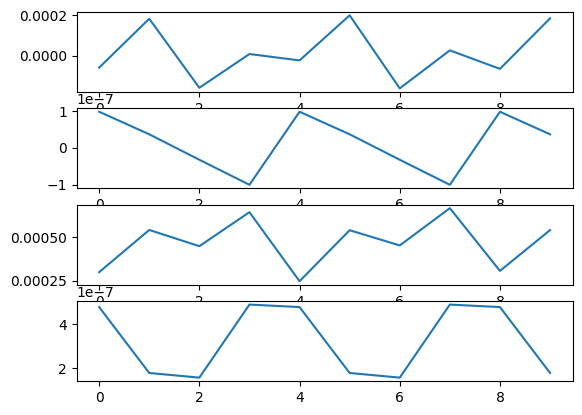

In [12]:
import matplotlib.pyplot as plt


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
ax1.plot(data["mean_1"][:10])
ax2.plot(data["mean_2"][:10])
ax3.plot(data["std_1"][:10])
ax4.plot(data["std_2"][:10])

In [ ]:
import numpy as np

print(np.mean(data["mean_1"]))
print(np.mean(data["mean_2"]))
print(np.mean(data["std_1"]))
print(np.mean(data["std_2"]))

3.0642152120380886e-07
5.51919566581585e-10
0.0004947273946260774
3.263592814878541e-07


In [15]:
np.mean(data["std_1"])/np.mean(data["mean_1"])

1614.5321408316534

In [16]:
np.mean(data["std_2"])/np.mean(data["mean_2"])

591.3167447735549